# Biological Sequence Analysis using Profile Hidden Markov Models
### Machine Learning Final Project
##### Mírian Francielle da Silva

In this project I used **Hidden Markov Model** (HMM), a probabilistic model to analyze **multiple sequence alignment** (msa) of proteins.

In the model, each column of symbols in the alignment is represented by a frequency distribution of the symbols (called a "state"), and insertions and deletions are represented by other states. One moves through the model along a particular path from state to state in a Markov chain (i.e., random choice of next move), trying to match a given sequence. The next matching symbol is chosen from each state, recording its probability (frequency) and also the probability of going to that state from a previous one (the transition probability). 

State and transition probabilities are multiplied to obtain a probability of the given sequence. The hidden nature of the HMM is due to the lack of information about the value of a specific state, which is instead represented by a probability distribution over all possible values.

When designing a HMM, the most important criteria are the number of states and the transitions between them.

### HMM Problems:
To analyse and describe data with HMMs, three major problems must be solved. 
- _What is the probability of an observed sequence according to a given model?_ 
This can be calculated using the forward algorithm and the result can be used, among others, to decide which model in a collection of HMMs best describes an observation.
- _The next problem is to find the most probable state sequence to have emitted an observation._
This state sequence can be used to determine the process which has caused the observation and is calculated with the Viterbi algorithm. 
- _The third problem is to optimize the model, to maximize the probabilities of given observations._
The best-known method for HMM training is the Baum-Welch, aka, Expectation Maximization training algorithm.


In [2]:
#Python tools for computational molecular biology
%pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Hidden Markov Models learn library
%pip install hmmlearn

Note: you may need to restart the kernel to use updated packages.


In [4]:
#Another Hidden Markov Model library
%pip install pomegranate

Note: you may need to restart the kernel to use updated packages.


In [5]:
#For better visualizations
#%pip install pygraphviz

In [4]:
# Important modules 
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range, input

import argparse, sys

import matplotlib
import matplotlib as mpl
import matplotlib.style
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd 
import numpy as np
import Bio
import timeit

from Bio.Seq import Seq
from Bio import SeqIO
from sklearn.utils import shuffle
from scipy.io import loadmat
from scipy.stats import norm
from pomegranate import *

from hmmlearn import hmm
from multiprocessing import Pool, TimeoutError

In [5]:
print("Biopython v" + Bio.__version__)

Biopython v1.73


#### About dataset: 

The [Pfam](http://pfam.xfam.org/) database is a large collection of protein families, each represented by multiple sequence alignments and hidden Markov models (HMMs). 

[Pfam References](http://pfam.xfam.org/help?tab=helpReferencesBlock):
[The Pfam protein families database in 2019](https://academic.oup.com/nar/article/47/D1/D427/5144153): S. El-Gebali, J. Mistry, A. Bateman, S.R. Eddy, A. Luciani, S.C. Potter, M. Qureshi, L.J. Richardson, G.A. Salazar, A. Smart, E.L.L. Sonnhammer, L. Hirsh, L. Paladin, D. Piovesan, S.C.E. Tosatto, R.D. Finn
Nucleic Acids Research (2019)  doi: 10.1093/nar/gky995

__Dataset used: [Family: Miga (PF10265)](http://pfam.xfam.org/family/PF10265#alignBlock)__
Mitoguardin (Miga) was first identified in flies as a mitochondrial outer-membrane protein that promotes mitochondrial fusion. 

#### About file format: 
In bioinformatics and biochemistry, the FASTA format is a text-based format for representing either nucleotide sequences or amino acid (protein) sequences, in which nucleotides or amino acids are represented using single-letter codes. The format also allows for sequence names and comments to precede the sequences.

In [6]:
input_file = "PF10265_seed.fasta"
input_file_high_lenght = "miga.fasta"
input_file_small_lenght = "zincFinger.fasta"

#### Parsing sequence file formats:

In [7]:
def fasta_reader(input_file):
    from Bio.SeqIO.FastaIO import FastaIterator
    with open(input_file_small_lenght) as handle:
        for record in FastaIterator(handle):
            yield record
msa = []
for entry in fasta_reader(input_file_small_lenght):
    msa.append(entry.seq)
    #msa_train.append(entry.seq)
    print ("ID:", str(entry.id), "\t Lenght:", str("{:,d}".format(len(entry))) ) #This is header of fasta entry
    #print (repr(entry.seq), "\n") #This is sequence of specific fasta entry
    #print (str(entry.seq), "\n") #This is sequence of specific fasta entry
    
print(msa)

ID: ACE2_YEAST/603-627 	 Lenght: 31
ID: ACE2_YEAST/633-657 	 Lenght: 31
ID: ADR1_YEAST/104-126 	 Lenght: 31
ID: ADR1_YEAST/132-155 	 Lenght: 31
ID: B5RIE4_DROME/222-244 	 Lenght: 31
ID: B5RIE4_DROME/306-328 	 Lenght: 31
ID: BNC1_HUMAN/720-743 	 Lenght: 31
ID: BNC1_HUMAN/928-951 	 Lenght: 31
ID: BRLA_EMENI/350-375 	 Lenght: 31
[Seq('FECLY-PNCN---KVFKRRYNIRSHIQT--H', SingleLetterAlphabet()), Seq('YSCDF-PGCT---KAFVRNHDLIRHKIS--H', SingleLetterAlphabet()), Seq('FVCE---VCT---RAFARQEHLKRHYRS--H', SingleLetterAlphabet()), Seq('YPCG---LCN---RCFTRRDLLIRHAQK-IH', SingleLetterAlphabet()), Seq('FTCK---ICS---RSFGYKHVLQNHERT--H', SingleLetterAlphabet()), Seq('YTCE---ICD---GKFSDSNQLKSHMLV--H', SingleLetterAlphabet()), Seq('FQCD---ICK---KTFKNACSVKIHHKN-MH', SingleLetterAlphabet()), Seq('ITCH---LCQ---KTYSNKGTFRAHYKT-VH', SingleLetterAlphabet()), Seq('HVCWV-PGCH---RAFSRSDNLNAHYTK-TH', SingleLetterAlphabet())]


In [8]:
import warnings
warnings.filterwarnings('ignore')

hmm = HiddenMarkovModel()
model = HiddenMarkovModel( "Global Alignment")

# Distribution for insertions
insertions_distributions = DiscreteDistribution( { 'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 } )

# Create the insert states
i0 = State( insertions_distributions, name="I0" )
i1 = State( insertions_distributions, name="I1" )
i2 = State( insertions_distributions, name="I2" )
i3 = State( insertions_distributions, name="I3" )

# Create the match states
m1 = State( DiscreteDistribution({ "A": 0.95, 'C': 0.01, 'G': 0.01, 'T': 0.02 }) , name="M1" )
m2 = State( DiscreteDistribution({ "A": 0.003, 'C': 0.99, 'G': 0.003, 'T': 0.004 }) , name="M2" )
m3 = State( DiscreteDistribution({ "A": 0.01, 'C': 0.01, 'G': 0.01, 'T': 0.97 }) , name="M3" )

# Create the delete states
d1 = State( None, name="D1" )
d2 = State( None, name="D2" )
d3 = State( None, name="D3" )

# Add all the states to the model
model.add_states( [i0, i1, i2, i3, m1, m2, m3, d1, d2, d3 ] )

# Create transitions from match states
model.add_transition( model.start, m1, 0.9 )
model.add_transition( model.start, i0, 0.1 )
model.add_transition( m1, m2, 0.9 )
model.add_transition( m1, i1, 0.05 )
model.add_transition( m1, d2, 0.05 )
model.add_transition( m2, m3, 0.9 )
model.add_transition( m2, i2, 0.05 )
model.add_transition( m2, d3, 0.05 )
model.add_transition( m3, model.end, 0.9 )
model.add_transition( m3, i3, 0.1 )

# Create transitions from insert states
model.add_transition( i0, i0, 0.70 )
model.add_transition( i0, d1, 0.15 )
model.add_transition( i0, m1, 0.15 )

model.add_transition( i1, i1, 0.70 )
model.add_transition( i1, d2, 0.15 )
model.add_transition( i1, m2, 0.15 )

model.add_transition( i2, i2, 0.70 )
model.add_transition( i2, d3, 0.15 )
model.add_transition( i2, m3, 0.15 )

model.add_transition( i3, i3, 0.85 )
model.add_transition( i3, model.end, 0.15 )

# Create transitions from delete states
model.add_transition( d1, d2, 0.15 )
model.add_transition( d1, i1, 0.15 )
model.add_transition( d1, m2, 0.70 ) 

model.add_transition( d2, d3, 0.15 )
model.add_transition( d2, i2, 0.15 )
model.add_transition( d2, m3, 0.70 )

model.add_transition( d3, i3, 0.30 )
model.add_transition( d3, model.end, 0.70 )

A Hidden Markov Model (HMM) is a directed graphical model where nodes are hidden states which contain an observed emission distribution and edges contain the probability of transitioning from one hidden state to another. HMMs allow you to tag each observation in a variable length sequence with the most likely hidden state according to the model.

Sequence: 'ACT'  -- Log Probability: -0.5132449003570658 -- Path: M1 M2 M3
Sequence: 'GGC'  -- Log Probability: -11.048101241343396 -- Path: I0 I0 D1 M2 D3
Sequence: 'GAT'  -- Log Probability: -9.125519674022627 -- Path: I0 M1 D2 M3
Sequence: 'ACC'  -- Log Probability: -5.0879558788604475 -- Path: M1 M2 M3


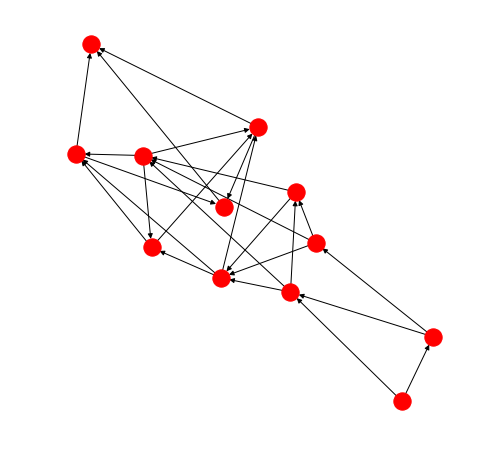

In [9]:
# Call bake to finalize the structure of the model.
model.bake()

plt.figure(figsize=(6,6))
model.plot()

for sequence in map( list, ('ACT', 'GGC', 'GAT', 'ACC') ):
    logp, path = model.viterbi( sequence )
    print ("Sequence: '{}'  -- Log Probability: {} -- Path: {}".format(''.join( sequence ), logp, " ".join( state.name for idx, state in path[1:-1] ) ))

In [10]:
#for sequence in map( list, (msa[0],msa[1]) ):
#    logp, path = model.viterbi( sequence )
#    print ("Sequence: '{}'  -- Log Probability: {} -- Path: {}".format(
#        ''.join( sequence ), logp, " ".join( state.name for idx, state in path[1:-1] ) ))

In [11]:
for sequence in map( list, ('A', 'GA', 'AC', 'AT', 'ATCC', 'ACGTG', 'ATTT', 'TACCCTC', 'TGTCAACACT') ):
    logp, path = model.viterbi( sequence )
    print ("Sequence: '{}'  -- Log Probability: {} -- Path: {}".format(
        ''.join( sequence ), logp, " ".join( state.name for idx, state in path[1:-1] ) ))

Sequence: 'A'  -- Log Probability: -5.406181012423981 -- Path: M1 D2 D3
Sequence: 'GA'  -- Log Probability: -10.88681993576597 -- Path: I0 M1 D2 D3
Sequence: 'AC'  -- Log Probability: -3.6244718790494277 -- Path: M1 M2 D3
Sequence: 'AT'  -- Log Probability: -3.644880750680635 -- Path: M1 D2 M3
Sequence: 'ATCC'  -- Log Probability: -10.674332964640293 -- Path: M1 D2 M3 I3 I3
Sequence: 'ACGTG'  -- Log Probability: -10.393824835172445 -- Path: M1 M2 I2 I2 I2 D3
Sequence: 'ATTT'  -- Log Probability: -8.67126440174503 -- Path: M1 I1 I1 D2 M3
Sequence: 'TACCCTC'  -- Log Probability: -16.903451796110275 -- Path: I0 I0 I0 I0 D1 M2 M3 I3
Sequence: 'TGTCAACACT'  -- Log Probability: -16.451699654050792 -- Path: I0 I0 I0 I0 I0 I0 I0 M1 M2 M3


In [12]:
def path_to_alignment( x, y, path ):
    """
    This function will take in two sequences, and the ML path which is their alignment,
    and insert dashes appropriately to make them appear aligned. This consists only of
    adding a dash to the model sequence for every insert in the path appropriately, and
    a dash in the observed sequence for every delete in the path appropriately.
    """
    
    for i, (index, state) in enumerate( path[1:-1] ):
        name = state.name
        
        if name.startswith( 'D' ):
            y = y[:i] + '-' + y[i:]
        elif name.startswith( 'I' ):
            x = x[:i] + '-' + x[i:]

    return x, y

for sequence in map( list, ('A', 'GA', 'AC', 'AT', 'ATCC', 'ACGTG', 'ATTT', 'TACCCTC', 'TGTCAACACT') ):
    logp, path = model.viterbi( sequence )
    x, y = path_to_alignment( 'ACT', ''.join(sequence), path )
    
    print ("Sequence: {}, Log Probability: {}".format( ''.join(sequence), logp ))
    print ("{}\n{}".format( x, y ))

Sequence: A, Log Probability: -5.406181012423981
ACT
A--
Sequence: GA, Log Probability: -10.88681993576597
-ACT
GA--
Sequence: AC, Log Probability: -3.6244718790494277
ACT
AC-
Sequence: AT, Log Probability: -3.644880750680635
ACT
A-T
Sequence: ATCC, Log Probability: -10.674332964640293
ACT--
A-TCC
Sequence: ACGTG, Log Probability: -10.393824835172445
AC---T
ACGTG-
Sequence: ATTT, Log Probability: -8.67126440174503
A--CT
ATT-T
Sequence: TACCCTC, Log Probability: -16.903451796110275
----ACT-
TACC-CTC
Sequence: TGTCAACACT, Log Probability: -16.451699654050792
-------ACT
TGTCAACACT
